In [177]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

Set random seed for reproducibility


In [178]:
torch.manual_seed(42)
np.random.seed(42)

Device configuration


In [179]:
device = "mps"
print(f"Using device: {device}")

Using device: mps


In [180]:
seq_len = 12

Load and prepare data


Create a unique location identifier and time key


In [181]:
data = pd.read_csv("./data/rnn_full_data.csv")
data["time_key"] = data["Year"] * 12 + data["Month"]
data["location_key"] = data["Location Group"] + "_" + data["District"].astype(str)
data = pd.get_dummies(data, columns=["Location Group", "District"])
location2idx = {location: i for i, location in enumerate(data["location_key"].unique())}
time2idx = {time: i for i, time in enumerate(data["time_key"].unique())}
data["location_id"] = data["location_key"].map(location2idx)
data

,Year,Month,holiday_count,sin_month,cos_month,crime_count,time_key,location_key,Location Group_EDUCATIONAL,Location Group_FINANCIAL,...,District_16.0,District_17.0,District_18.0,District_19.0,District_20.0,District_22.0,District_24.0,District_25.0,District_31.0,location_id
0,2018,1,2.0,0.0,1.000000,28.0,24217,EDUCATIONAL_1.0,True,False,...,False,False,False,False,False,False,False,False,False,0
1,2018,1,2.0,0.0,1.000000,23.0,24217,FINANCIAL_1.0,False,True,...,False,False,False,False,False,False,False,False,False,1
2,2018,1,2.0,0.0,1.000000,189.0,24217,FOOD_ENTERTAINMENT_1.0,False,False,...,False,False,False,False,False,False,False,False,False,2
3,2018,1,2.0,0.0,1.000000,16.0,24217,GOVERNMENT_1.0,False,False,...,False,False,False,False,False,False,False,False,False,3
4,2018,1,2.0,0.0,1.000000,28.0,24217,OFFICE_BUSINESS_1.0,False,False,...,False,False,False,False,False,False,False,False,False,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20220,2024,12,1.0,-0.5,0.866025,311.0,24300,STREET_OUTDOOR_25.0,False,False,...,False,False,False,False,False,False,False,True,False,239
20221,2024,12,1.0,-0.5,0.866025,26.0,24300,TRANSPORTATION_25.0,False,False,...,False,False,False,False,False,False,False,True,False,240
20222,2024,12,1.0,-0.5,0.866025,1.0,24300,OTHER_31.0,False,False,...,False,False,False,False,False,False,False,False,True,243
20223,2024,12,1.0,-0.5,0.866025,1.0,24300,RETAIL_31.0,False,False,...,False,False,False,False,False,False,False,False,True,248


In [182]:
features = ["crime_count", "sin_month", "cos_month", "holiday_count"]
pivot_df = data.pivot(
    index="time_key",
    columns="location_id",
    values="crime_count",
)
pivot_df = pivot_df.fillna(0)  # handle missing values if necessary
# n_feature = pivot_df.columns.get_level_values(0).nunique()
n_location = pivot_df.columns.get_level_values(0).nunique()
time_features = pd.DataFrame(index=pivot_df.index)
time_features["holiday_count"] = data.groupby("time_key")["holiday_count"].first()
time_features["sin_month"] = data.groupby("time_key")["sin_month"].first()
time_features["cos_month"] = data.groupby("time_key")["cos_month"].first()
pivot_df.shape, time_features.shape

((84, 251), (84, 3))

In [183]:
train_size = int((len(pivot_df) - seq_len) * 0.75)
from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler()
# scaled_crime_count = scaler.fit_transform(pivot_df)
# scaled_crime_count = pd.DataFrame(
#     scaled_crime_count, index=pivot_df.index, columns=pivot_df.columns
# )
scaled_crime_count = pivot_df.copy()
scaled_crime_count

location_id,0,1,2,3,4,5,6,7,8,9,...,241,242,243,244,245,246,247,248,249,250
time_key,,,,,,,,,,,,,,,,,,,,,
24217,28.0,23.0,189.0,16.0,28.0,143.0,88.0,106.0,292.0,196.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24218,25.0,14.0,149.0,19.0,36.0,138.0,68.0,98.0,209.0,189.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24219,26.0,17.0,183.0,12.0,31.0,170.0,69.0,107.0,241.0,227.0,...,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
24220,31.0,23.0,180.0,20.0,34.0,143.0,97.0,108.0,229.0,222.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24221,28.0,17.0,200.0,21.0,32.0,174.0,100.0,109.0,274.0,340.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24296,22.0,5.0,89.0,22.0,53.0,96.0,139.0,140.0,242.0,507.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
24297,20.0,15.0,104.0,19.0,40.0,71.0,142.0,165.0,185.0,418.0,...,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0
24298,33.0,10.0,135.0,18.0,73.0,70.0,138.0,174.0,220.0,399.0,...,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [184]:
def create_sequences(crime_counts_df, time_features_df, seq_length=12):
    X_seq = []
    y_vals = []
    loc_idx = []
    time_idx = []
    T = crime_counts_df.shape[0]
    location_ids = crime_counts_df.columns
    for col in location_ids:
        crime_series = crime_counts_df[col].values
        for i in range(T - seq_length):
            crime_window = crime_series[i : i + seq_length].reshape(
                -1, 1
            )  # shape (seq_length, 1)
            tf_window = time_features_df.iloc[i : i + seq_length].values
            window_features = np.hstack([crime_window, tf_window])
            y_val = crime_series[i + seq_length]
            X_seq.append(window_features)
            y_vals.append(y_val)
            loc_idx.append(col)
            time_idx.append(i)
    X_seq = np.array(X_seq)  # shape => (#samples, seq_length, 4)
    y_vals = np.array(y_vals)  # shape => (#samples,)
    loc_idx = np.array(loc_idx)  # shape => (#samples,)
    time_idx = np.array(time_idx)  # shape => (#samples,)
    return X_seq, y_vals, loc_idx, time_idx


seq_length = 12
X_seq, y, loc_idx, time_idx = create_sequences(
    scaled_crime_count, time_features, seq_length=seq_length
)
n_feature = X_seq.shape[2]

print("X_seq shape:", X_seq.shape)  # (#samples, seq_length, n_feature)
print("y shape:", y.shape)  # (#samples,)
print("loc_idx shape:", loc_idx.shape)  # (#samples,)
print("time_idx shape:", time_idx.shape)  # (#samples,)

X_seq shape: (18072, 12, 4)
y shape: (18072,)
loc_idx shape: (18072,)
time_idx shape: (18072,)


In [185]:
train_mask = time_idx < train_size
test_mask = time_idx >= train_size

X_train = X_seq[train_mask]
y_train = y[train_mask]
loc_train = loc_idx[train_mask]
time_train = time_idx[train_mask]

X_test = X_seq[test_mask]
y_test = y[test_mask]
loc_test = loc_idx[test_mask]
time_test = time_idx[test_mask]

print("Train shapes:", X_train.shape, loc_train.shape, y_train.shape)
print("Test shapes:", X_test.shape, loc_test.shape, y_test.shape)

Train shapes: (13554, 12, 4) (13554,) (13554,)
Test shapes: (4518, 12, 4) (4518,) (4518,)


In [186]:
from torch.utils.data import Dataset, DataLoader


class CrimeDataset(Dataset):
    def __init__(self, X, y, loc_idx, time_idx):
        self.X = X  # n_sequences, seq_len, n_location
        self.y = y  # n_sequences, n_location
        self.loc_idx = loc_idx
        self.time_idx = time_idx

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        X = torch.tensor(self.X[idx], dtype=torch.float32)
        y = torch.tensor(self.y[idx], dtype=torch.float32)
        loc_idx = torch.tensor(self.loc_idx[idx], dtype=torch.long)
        time_idx = torch.tensor(self.time_idx[idx], dtype=torch.long)
        return X, y, loc_idx, time_idx

In [187]:
num_size = n_feature
cat_size = n_location
batch_size = 64
hidden_size = 128
num_layers = 2
embed_dim = 16
output_size = 1
num_epochs = 50
dropout = 0.1
learning_rate = 0.001

In [188]:
train_dataset = CrimeDataset(X_train, y_train, loc_train, time_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = CrimeDataset(X_test, y_test, loc_test, time_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [189]:
for X_batch, y_batch, loc_batch, time_batch in train_loader:
    print(f"X_batch shape: {X_batch.shape}")
    print(f"y_batch shape: {y_batch.shape}")
    print(f"loc_batch shape: {loc_batch.shape}")
    print(f"time_batch shape: {time_batch.shape}")
    break

X_batch shape: torch.Size([64, 12, 4])
y_batch shape: torch.Size([64])
loc_batch shape: torch.Size([64])
time_batch shape: torch.Size([64])


In [190]:
class CrimeLSTM(nn.Module):
    def __init__(
        self,
        num_size,
        cat_size,
        hidden_size,
        embed_dim,
        num_layers,
        output_size,
        dropout,
    ):
        super(CrimeLSTM, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(cat_size, embed_dim)
        self.lstm = nn.LSTM(
            input_size=num_size + embed_dim,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
        )
        self.fc1 = nn.Linear(hidden_size, 64)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(64, output_size)

    def forward(self, X, loc, h_0, c_0):
        """
        x: [batch_size, seq_len, n_feature]
        h_0, c_0: [num_layers, batch_size, hidden_size]
        output: [batch_size, n_location, output_size]
        """
        _, seq_len, _ = X.shape
        loc_embed = self.embedding(loc)
        loc_embed = loc_embed.unsqueeze(1).repeat(1, seq_len, 1)
        lstm_input = torch.cat((X, loc_embed), dim=2)
        lstm_output, (h_n, c_n) = self.lstm(lstm_input, (h_0, c_0))
        last_output = lstm_output[:, -1, :]
        fc_out = self.fc1(last_output)
        fc_out = self.relu(fc_out)
        fc_out = self.dropout(fc_out)
        fc_out = self.fc2(fc_out)  # [batch_size*n_location, output_size]
        return fc_out, (h_n, c_n)

In [191]:
model = CrimeLSTM(
    num_size, cat_size, hidden_size, embed_dim, num_layers, output_size, dropout
).to(device)
print(model)

CrimeLSTM(
  (embedding): Embedding(251, 16)
  (lstm): LSTM(20, 128, num_layers=2, batch_first=True)
  (fc1): Linear(in_features=128, out_features=64, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
)


Define loss function and optimizer


In [192]:
criterion = nn.MSELoss()

Training function


In [193]:
# Validation
def evaluate_model(model, test_loader, criterion):
    model.eval()
    val_loss = 0
    num_batches = 0
    with torch.no_grad():
        for X_batch, y_batch, loc_batch, _ in test_loader:
            X_batch, y_batch, loc_batch = (
                X_batch.to(device),
                y_batch.to(device),
                loc_batch.to(device),
            )
            curr_batch_size = X_batch.shape[0]
            h = torch.zeros(num_layers, curr_batch_size, hidden_size).to(device)
            c = torch.zeros(num_layers, curr_batch_size, hidden_size).to(device)
            score, (_, _) = model(X_batch, loc_batch, h, c)
            score = score.view(curr_batch_size)
            loss = criterion(score, y_batch)
            val_loss += loss.item()
            num_batches += 1
    total_val_loss = val_loss / num_batches
    return total_val_loss

In [194]:
start_time = time.time()
train_losses = []
val_losses = []
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode="min",  # because we're monitoring loss
    factor=0.5,  # how much to reduce the LR
    patience=4,  # how many epochs to wait
    threshold=1e-4,  # min improvement to be considered
    cooldown=0,  # cooldown after reduction
    min_lr=1e-6,  # don’t go below this
)
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    num_batches = 0
    for X_batch, y_batch, loc_batch, _ in train_loader:
        optimizer.zero_grad()
        curr_batch_size = X_batch.shape[0]
        X_batch, y_batch, loc_batch = (
            X_batch.to(device),
            y_batch.to(device),
            loc_batch.to(device),
        )
        h = torch.zeros(num_layers, curr_batch_size, hidden_size).to(device)
        c = torch.zeros(num_layers, curr_batch_size, hidden_size).to(device)
        score, (_, _) = model(X_batch, loc_batch, h, c)
        score = score.reshape(curr_batch_size)
        loss = criterion(score, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        num_batches += 1
    train_loss /= num_batches
    train_losses.append(train_loss)
    val_loss = evaluate_model(model, test_loader, criterion)
    val_losses.append(val_loss)
    scheduler.step(val_loss)
    print(
        f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.12f}, Val Loss: {val_loss:.12f}, LR: {scheduler.get_last_lr()[0]:.12f}"
    )

Epoch [1/50], Train Loss: 12977.469645374225, Val Loss: 4985.638194887571, LR: 0.001000000000
Epoch [2/50], Train Loss: 1777.053090077526, Val Loss: 920.867136342005, LR: 0.001000000000
Epoch [3/50], Train Loss: 742.650827551788, Val Loss: 447.590314327831, LR: 0.001000000000
Epoch [4/50], Train Loss: 634.907557973322, Val Loss: 442.303412212452, LR: 0.001000000000
Epoch [5/50], Train Loss: 599.742203370580, Val Loss: 377.720794017886, LR: 0.001000000000
Epoch [6/50], Train Loss: 553.511420483859, Val Loss: 576.299241827407, LR: 0.001000000000
Epoch [7/50], Train Loss: 565.495778317721, Val Loss: 345.324377167393, LR: 0.001000000000
Epoch [8/50], Train Loss: 580.498589317754, Val Loss: 351.973349323575, LR: 0.001000000000
Epoch [9/50], Train Loss: 564.454943423001, Val Loss: 535.281139081213, LR: 0.001000000000
Epoch [10/50], Train Loss: 558.912730055035, Val Loss: 354.504576630156, LR: 0.001000000000
Epoch [11/50], Train Loss: 547.742134454115, Val Loss: 322.844924939980, LR: 0.001000

Train the model


Plot training and validation loss


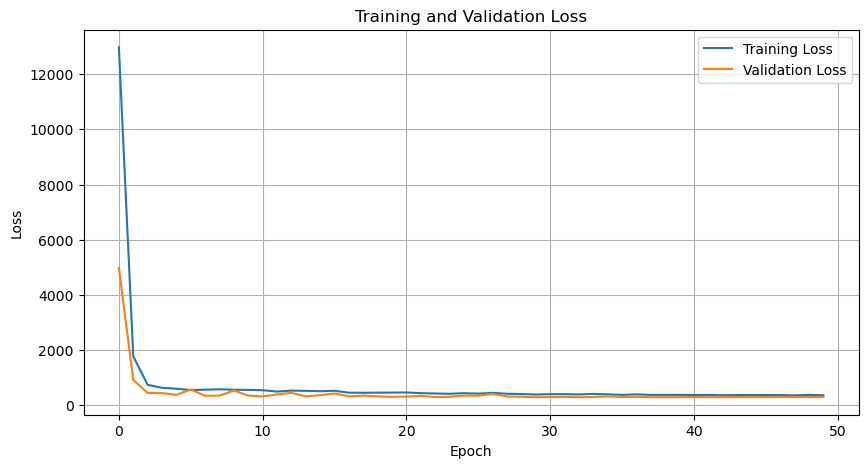

In [195]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.savefig("./figure/training_validation_loss.pdf", format="pdf")
plt.show()

In [ ]:
def predictions(model, train_loader, test_loader):
    result = np.zeros(
        (
            (len(train_loader.dataset) + len(test_loader.dataset)) // n_location,
            n_location,
            2,
        )
    )

    def get_result(result, loader):
        model.eval()
        with torch.no_grad():
            for i, (X_batch, y_batch, loc_batch, time_batch) in enumerate(loader):
                curr_batch_size = X_batch.shape[0]
                X_batch, y_batch, loc_batch = (
                    X_batch.to(device),
                    y_batch.to(device),
                    loc_batch.to(device),
                )
                h = torch.zeros(num_layers, curr_batch_size, hidden_size).to(device)
                c = torch.zeros(num_layers, curr_batch_size, hidden_size).to(device)
                score, (_, _) = model(X_batch, loc_batch, h, c)
                score = score.reshape(curr_batch_size)
                result[time_batch, loc_batch.cpu().numpy(), 0] = score.cpu().numpy()
                result[time_batch, loc_batch.cpu().numpy(), 1] = y_batch.cpu().numpy()

    get_result(result, train_loader)
    get_result(result, test_loader)
    return result

In [ ]:
result_scaled = predictions(model, train_loader, test_loader)
# result_unscaled = result_scaled.copy()
# result_unscaled[:, :, 0] = (
#     result_scaled[:, :, 0] * (scaler.data_max_[0] - scaler.data_min_[0])
#     + scaler.data_min_[0]
# )
# result_unscaled = np.round(result_unscaled)
result_scaled = np.round(result_scaled)

array([[ 22.,  22.],
       [ 15.,  21.],
       [162., 185.],
       [ 18.,  11.],
       [ 40.,  40.],
       [130., 128.],
       [ 63.,  74.],
       [109.,  86.],
       [232., 260.],
       [176., 170.],
       [136., 173.],
       [ 33.,  19.],
       [  5.,  16.],
       [ 22.,  31.],
       [ 19.,  21.],
       [  7.,   4.],
       [ 46.,  45.],
       [ 36.,  45.],
       [347., 367.],
       [ 52.,  59.],
       [221., 200.],
       [ 31.,  29.],
       [ 12.,  13.],
       [  3.,   4.],
       [ 13.,   8.],
       [  7.,   6.],
       [  4.,   5.],
       [ 35.,  40.],
       [ 39.,  37.],
       [462., 525.],
       [ 25.,  22.],
       [269., 231.],
       [ 28.,  33.],
       [ 30.,  40.],
       [  5.,   6.],
       [ 16.,  17.],
       [ 11.,   9.],
       [  6.,   3.],
       [ 32.,  41.],
       [ 39.,  29.],
       [512., 519.],
       [ 53.,  67.],
       [314., 278.],
       [ 24.,  34.],
       [ 24.,  16.],
       [  1.,   2.],
       [  8.,  11.],
       [  6.,

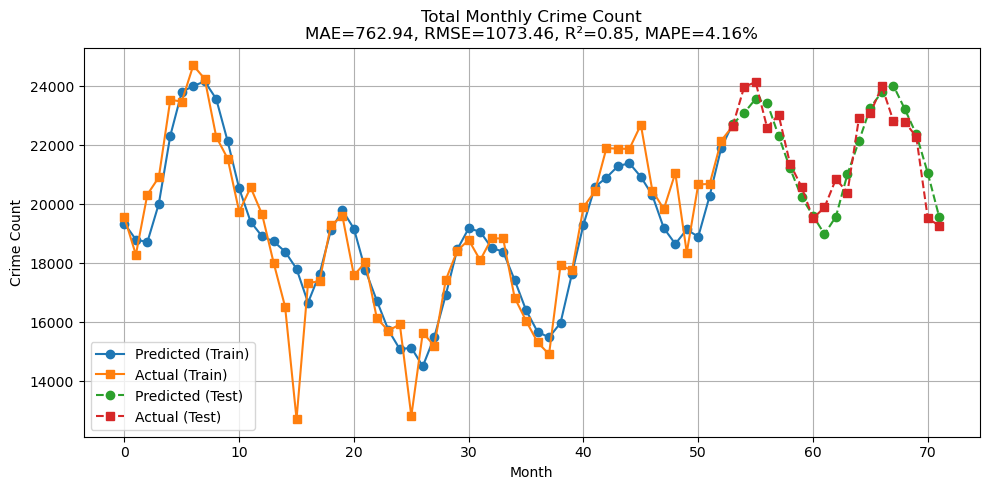

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score

predict = result_scaled[..., 0]
actual = result_scaled[..., 1]

monthly_predicted = predict.sum(axis=1)
monthly_actual = actual.sum(axis=1)

# Evaluation metrics for total monthly prediction
mae = mean_absolute_error(monthly_actual, monthly_predicted)
rmse = root_mean_squared_error(monthly_actual, monthly_predicted)
r2 = r2_score(monthly_actual, monthly_predicted)
mape = (
    np.mean(np.abs((monthly_actual - monthly_predicted) / (monthly_actual + 1e-8)))
    * 100
)

# Plotting total predicted vs actual
x = np.arange(len(monthly_predicted))
plt.figure(figsize=(10, 5))
plt.plot(
    x[:train_size],
    monthly_predicted[:train_size],
    label="Predicted (Train)",
    marker="o",
)
plt.plot(
    x[:train_size], monthly_actual[:train_size], label="Actual (Train)", marker="s"
)
plt.plot(
    x[train_size - 1 :],
    monthly_predicted[train_size - 1 :],
    label="Predicted (Test)",
    marker="o",
    linestyle="--",
)
plt.plot(
    x[train_size - 1 :],
    monthly_actual[train_size - 1 :],
    label="Actual (Test)",
    marker="s",
    linestyle="--",
)
plt.title(
    f"Total Monthly Crime Count\nMAE={mae:.2f}, RMSE={rmse:.2f}, R²={r2:.2f}, MAPE={mape:.2f}%"
)
plt.xlabel("Month")
plt.ylabel("Crime Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("./figure/total_monthly_crime_count_lstm.pdf", format="pdf")
plt.show()

In [214]:
def evaluate_all_locations(predicted, actual, min_actual_for_mape=10):
    n_locations = actual.shape[1]
    maes, rmses, r2s, mapes = [], [], [], []

    for loc_idx in range(n_locations):
        y_true = actual[:, loc_idx]
        y_pred = predicted[:, loc_idx]

        maes.append(mean_absolute_error(y_true, y_pred))
        rmses.append(root_mean_squared_error(y_true, y_pred))
        r2s.append(r2_score(y_true, y_pred))

        # Filtered MAPE for better stability
        mask = np.abs(y_true) >= min_actual_for_mape
        if mask.sum() > 0:
            mape = (
                np.mean(np.abs((y_true[mask] - y_pred[mask]) / (y_true[mask] + 1e-8)))
                * 100
            )
        else:
            mape = np.nan  # no valid points
        mapes.append(mape)

    print("📊 Evaluation Metrics Averaged Over All Locations:")
    print(f"▶ Mean MAE       : {np.nanmean(maes):.2f}")
    print(f"▶ Mean RMSE      : {np.nanmean(rmses):.2f}")
    print(f"▶ Mean R²        : {np.nanmean(r2s):.4f}")
    print(
        f"▶ Mean MAPE (%)  : {np.nanmean(mapes):.2f}% (filtered actual < {min_actual_for_mape})"
    )

In [215]:
test_result = result_scaled[train_size:]
evaluate_all_locations(test_result[:, :, 0], test_result[:, :, 1])

📊 Evaluation Metrics Averaged Over All Locations:
▶ Mean MAE       : 9.57
▶ Mean RMSE      : 11.80
▶ Mean R²        : -0.1252
▶ Mean MAPE (%)  : 20.22% (filtered actual < 10)


In [219]:
result_scaled[:, -1]

array([[-0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [-0.,  0.],
       [-0.,  0.],
       [-0.,  0.],
       [-0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [-0.,  0.],
       [-0.,  0.],
       [-0.,  0.],
       [-0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [-0.,  0.],
       [-0.,  0.],
       [-0.,  0.],
       [-0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [-0.,  0.],
       [-0.,  0.],
       [-0.,  0.],
       [-0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,